## Análise: Dados Experimentais da Radiação de Corpo Negro

#### Importar dados

In [1]:
import pandas as pd

df = [pd.read_csv('processed_data/s'+str(i)+'.csv', decimal=',', header=1)
    for i in range(1,6)]
df[0].head()

,θ ( graus ),θ rad,λ (metros),"Intensidade de luz, canal A ( % do máx. )"
0,0.0,0.0,0.0,290.1
1,0.0,0.0,0.0,291.4
2,0.0,0.0,0.0,290.5
3,0.0,0.0,0.0,289.5
4,0.0,0.0,0.0,292.8


#### Definir comprimento de onda e intensidade de luz

In [2]:
comp = [df[i][df[i].columns[2]] for i in range(0,5)]
ints = [df[i][df[i].columns[3]] for i in range(0,5)]

#### Plotar gráfico de intensidade x comprimento de onda

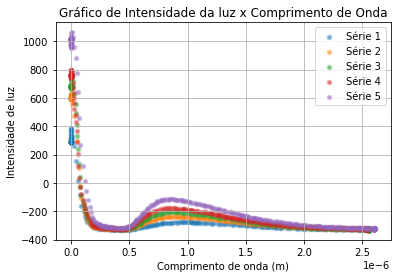

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.gcf()

for i in range(0,5):
    plt.scatter(comp[i], ints[i], label='Série '+str(i+1), 
               marker='.', lw=2.5, alpha=0.4)

plt.title('Gráfico de Intensidade da luz x Comprimento de Onda')
plt.xlabel('Comprimento de onda (m)')
plt.ylabel('Intensidade de luz')
plt.legend()
plt.grid()
plt.show()
fig.savefig('fig.png', bbox_inches='tight')

#### Ajustar a curva de Planck

Função: $\rho_T (\lambda) = n \frac{8 \pi h c}{\lambda^5} \frac{1}{exp(\frac{hc}{\lambda k T})-1} + m$

Onde $\rho_T$ é a função de radiância em função da temperatura, $\lambda$ é o comp. de onda, $n$ é uma normalização, $h$ é a constante de Planck, $c$ é a velocidade da luz, $k$ é a constante de Boltzmann, e $m$ é a constante de fundo.

Chutes iniciais: \
$n = 1$ \
$h = 6.6e-34$ \
$k = 1.38e-23$ \
$T = 2000$ \
$m = -325$

Os dados de comprimento de onda serão desconsiderados quando $\lambda \leq 0.5 \mu m$, pois representam dados quando a onda não é difratada, portanto são dados expúrios.

In [4]:
# Definir dados desconsiderando lambda <= 0.5um
xdata = [df[i][df[i][df[i].columns[2]]>=0.5e-6].reset_index()[df[i].columns[2]]
         for i in range(0,5)]
y = [df[i][df[i][df[i].columns[2]]>=0.5e-6].reset_index()[df[i].columns[3]]
     for i in range(0,5)]

In [5]:
# Definir função
import numpy as np

def planck_curve(x, n, m, T, k, h):
    c=3*10**8
    return (n * 
            (((8*np.pi*h*c) / (x**5))
             *
             (1 / (np.exp((h*c)/(x*k*T))-1))
            )
            + m
           )

In [6]:
# Realizar ajuste
from scipy.optimize import curve_fit
from lmfit import Model
from lmfit import Parameters

par = Parameters()
par.add('n', value=1, min=0)
par.add('m', value=-300)
par.add('T', value=2000)
par.add('k', value=1.38e-23)
par.add('h', value=6.6e-34)

pmodel = Model(planck_curve)
result = [pmodel.fit(y[i], x=xdata[i], params=par)
         for i in range(0,5)]

#### Parâmetros encontrados:

In [7]:
result[i].best_values

{'n': 0.005157344627627181,
 'm': -367.2653636306224,
 'T': 2282.686224904655,
 'k': 1.5171351383519568e-23,
 'h': 5.164238302013819e-34}

In [8]:
for i in range(0,5):
    print('Série {:.0f}: \n'.format(i),
        'n: {:.2e} \n'.format(result[i].best_values['n']),
        'm: {:.0f} \n'.format(result[i].best_values['m']),
        'T: {:.0f} K \n'.format(result[i].best_values['T']),
        'k: {:.2e} J⋅K^-1 \n'.format(result[i].best_values['k']),
        'h: {:.1e} J⋅s \n'.format(result[i].best_values['h']),
    )

Série 0: 
 n: 9.87e-04 
 m: -344 
 T: 3416 K 
 k: 2.05e-23 J⋅K^-1 
 h: 1.1e-33 J⋅s 

Série 1: 
 n: 1.98e-03 
 m: -350 
 T: 2601 K 
 k: 1.87e-23 J⋅K^-1 
 h: 7.6e-34 J⋅s 

Série 2: 
 n: 2.93e-03 
 m: -355 
 T: 2488 K 
 k: 1.60e-23 J⋅K^-1 
 h: 6.1e-34 J⋅s 

Série 3: 
 n: 5.79e-03 
 m: -358 
 T: 1685 K 
 k: 1.30e-23 J⋅K^-1 
 h: 3.3e-34 J⋅s 

Série 4: 
 n: 5.16e-03 
 m: -367 
 T: 2283 K 
 k: 1.52e-23 J⋅K^-1 
 h: 5.2e-34 J⋅s 



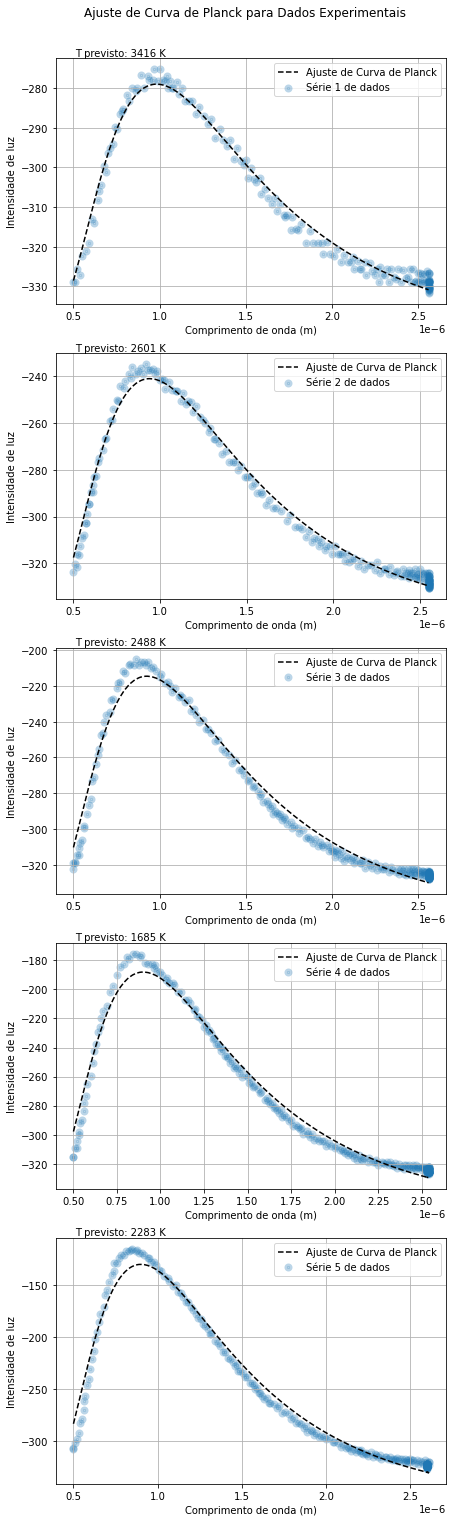

In [9]:
# Plotar dados com função prevista

fig, axs = plt.subplots(5, 1, figsize=(7,24))
fig.suptitle('Ajuste de Curva de Planck para Dados Experimentais')
fig.subplots_adjust(top=0.95)

for i in range(0,5):
    axs[i].scatter(xdata[i], y[i], label='Série '+str(i+1)+' de dados', 
               marker='.', linewidths=5, alpha=0.3)
    axs[i].plot(xdata[i], result[i].best_fit, label='Ajuste de Curva de Planck',
                ls='--', color='black')
    axs[i].annotate('T previsto: {:.0f} K'.format(result[i].best_values['T']), xy=(0.05, 1.01), xycoords='axes fraction')
    axs[i].set_xlabel('Comprimento de onda (m)')
    axs[i].set_ylabel('Intensidade de luz')
    axs[i].legend()
    axs[i].grid()

plt.show()
fig.savefig('adj.png', bbox_inches='tight')